# [microSAM](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html)
see https://github.com/computational-cell-analytics/micro-sam/blob/master/examples/use_as_library/instance_segmentation.py

In [1]:
import sys, os; sys.path += [os.path.join(os.path.expanduser('~'), 'thesis')]  # NOTE hardcoded project root to find shared util modules

from micro_sam import instance_segmentation, util
import imageio.v3 as imageio
import pandas as pd
import itertools as it
import os
from datetime import datetime

from util.label_studio_converter__brush import mask2rle
from util.plot import *


_cache_dir = os.path.join(os.path.expanduser('~'), '.cache', 'micro-sam', 'TEMPORARY-TIMING')

In [2]:
dataset_id = 'third'

models = 'vit_b vit_l vit_h'.split(' ')
iou_thresh = 0.88

cache_dir = os.path.join(_cache_dir, dataset_id)
os.makedirs(cache_dir, exist_ok=True)

In [3]:

out = pd.DataFrame()

for model in models:
  T0 = datetime.now()
  predictor = util.get_sam_model(model_type=model)
  T_load_predictor = (datetime.now() - T0).total_seconds()

  for imgid in [1]:

    pImage = f"../data/{dataset_id}/{imgid}.jpg"
    pEmbed = f"{cache_dir}/embed.{model}.{imgid}.zarr"
    pMasks = f"{cache_dir}/masks.{model}.{imgid}.npy"
    pRLEs  = f"{cache_dir}/rles.{model}.{imgid}.str"


    image = imageio.imread(pImage)

    print('LOADING'  if os.path.exists(pEmbed) else
          'WRITING', f'embedding cache at {pEmbed}')

    T0 = datetime.now()
    embeddings = util.precompute_image_embeddings(
      predictor, image, ndim = 2, save_path=pEmbed,
      tile_shape=(tile:=1024, tile), halo=(halo:=tile//4, halo)
    )
    T_embed = (datetime.now() - T0).total_seconds()

    T0 = datetime.now()
    amg = instance_segmentation.TiledAutomaticMaskGenerator(predictor)
    T_load_amg = (datetime.now() - T0).total_seconds()

    T0 = datetime.now()
    amg.initialize(image, embeddings, verbose=True)
    insts = amg.generate(pred_iou_thresh=iou_thresh)  # can try different

    masks = instance_segmentation.mask_data_to_segmentation(
      insts, shape=image.shape, with_background=True)        ## TODO: what does this function do with overlapping instances?
    T_segment = (datetime.now() - T0).total_seconds()

    np.save(pMasks, masks)

    rles = [mask2rle(I['segmentation'].astype(np.uint8)) for I in insts]
    with open(pRLEs, 'w') as f: f.write(str(rles))

    out = pd.concat([out, pd.DataFrame(dict(
      model = [model],
      imgid = [imgid],
      image = [pImage],
      embed = [pEmbed],
      masks = [pMasks],
      rles  = [pRLEs],
      T_embed = [T_embed],
      T_load_predictor = [T_load_predictor],
      T_load_amg = [T_load_amg],
      T_segment = [T_segment],
    ))], ignore_index=True)

WRITING embedding cache at /gpfs/space/home/eckhardt/.cache/micro-sam/TEMPORARY-TIMING/third/embed.vit_b.1.zarr


Predict image embeddings for tiles:  25%|██▌       | 1/4 [00:08<00:24,  8.13s/it]

Predict image embeddings for tiles:  50%|█████     | 2/4 [00:08<00:07,  3.59s/it]

Predict image embeddings for tiles:  75%|███████▌  | 3/4 [00:08<00:02,  2.11s/it]

Predict image embeddings for tiles: 100%|██████████| 4/4 [00:09<00:00,  1.41s/it]

Predict image embeddings for tiles: 100%|██████████| 4/4 [00:09<00:00,  2.31s/it]

Predict masks for point grid prompts:   6%|▋         | 1/16 [00:06<01:31,  6.08s/it]

Predict masks for point grid prompts:  12%|█▎        | 2/16 [00:07<00:44,  3.19s/it]

Predict masks for point grid prompts:  19%|█▉        | 3/16 [00:08<00:29,  2.26s/it]

Predict masks for point grid prompts:  25%|██▌       | 4/16 [00:09<00:22,  1.85s/it]

Predict masks for point grid prompts:  31%|███▏      | 5/16 [00:10<00:17,  1.59s/it]

Predict masks for point grid prompts:  38%|███▊      | 6/16 [00:11<00:14,  1.46s/it]

Predict masks for point grid prompts:  44%|████▍     | 7/16 [00:13<00:12,  1.37s/it]

Predict masks for point grid prompts:  50%|█████     | 8/16 [00:14<00:10,  1.29s/it]

Predict masks for point grid prompts:  56%|█████▋    | 9/16 [00:15<00:08,  1.26s/it]

Predict masks for point grid prompts:  62%|██████▎   | 10/16 [00:16<00:07,  1.25s/it]

Predict masks for point grid prompts:  69%|██████▉   | 11/16 [00:17<00:06,  1.23s/it]

Predict masks for point grid prompts:  75%|███████▌  | 12/16 [00:19<00:04,  1.24s/it]

Predict masks for point grid prompts:  81%|████████▏ | 13/16 [00:20<00:03,  1.26s/it]

Predict masks for point grid prompts:  88%|████████▊ | 14/16 [00:21<00:02,  1.25s/it]

Predict masks for point grid prompts:  94%|█████████▍| 15/16 [00:22<00:01,  1.24s/it]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:24<00:00,  1.32s/it]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


Compute masks for tile:  25%|██▌       | 1/4 [00:24<01:13, 24.43s/it]

Predict masks for point grid prompts:   6%|▋         | 1/16 [00:01<00:16,  1.09s/it]

Predict masks for point grid prompts:  12%|█▎        | 2/16 [00:02<00:15,  1.11s/it]

Predict masks for point grid prompts:  19%|█▉        | 3/16 [00:03<00:14,  1.12s/it]

Predict masks for point grid prompts:  25%|██▌       | 4/16 [00:04<00:13,  1.12s/it]

Predict masks for point grid prompts:  31%|███▏      | 5/16 [00:05<00:12,  1.10s/it]

Predict masks for point grid prompts:  38%|███▊      | 6/16 [00:06<00:11,  1.10s/it]

Predict masks for point grid prompts:  44%|████▍     | 7/16 [00:07<00:09,  1.11s/it]

Predict masks for point grid prompts:  50%|█████     | 8/16 [00:08<00:08,  1.11s/it]

Predict masks for point grid prompts:  56%|█████▋    | 9/16 [00:09<00:07,  1.11s/it]

Predict masks for point grid prompts:  62%|██████▎   | 10/16 [00:11<00:06,  1.12s/it]

Predict masks for point grid prompts:  69%|██████▉   | 11/16 [00:12<00:05,  1.13s/it]

Predict masks for point grid prompts:  75%|███████▌  | 12/16 [00:13<00:04,  1.16s/it]

Predict masks for point grid prompts:  81%|████████▏ | 13/16 [00:14<00:03,  1.19s/it]

Predict masks for point grid prompts:  88%|████████▊ | 14/16 [00:16<00:02,  1.21s/it]

Predict masks for point grid prompts:  94%|█████████▍| 15/16 [00:17<00:01,  1.19s/it]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:18<00:00,  1.18s/it]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


Compute masks for tile:  50%|█████     | 2/4 [00:42<00:41, 20.85s/it]

Predict masks for point grid prompts:   6%|▋         | 1/16 [00:00<00:14,  1.04it/s]

Predict masks for point grid prompts:  12%|█▎        | 2/16 [00:01<00:13,  1.03it/s]

Predict masks for point grid prompts:  19%|█▉        | 3/16 [00:02<00:12,  1.01it/s]

Predict masks for point grid prompts:  25%|██▌       | 4/16 [00:03<00:11,  1.01it/s]

Predict masks for point grid prompts:  31%|███▏      | 5/16 [00:04<00:10,  1.02it/s]

Predict masks for point grid prompts:  38%|███▊      | 6/16 [00:05<00:09,  1.02it/s]

Predict masks for point grid prompts:  44%|████▍     | 7/16 [00:06<00:08,  1.02it/s]

Predict masks for point grid prompts:  50%|█████     | 8/16 [00:07<00:07,  1.01it/s]

Predict masks for point grid prompts:  56%|█████▋    | 9/16 [00:08<00:06,  1.03it/s]

Predict masks for point grid prompts:  62%|██████▎   | 10/16 [00:09<00:05,  1.04it/s]

Predict masks for point grid prompts:  69%|██████▉   | 11/16 [00:10<00:04,  1.03it/s]

Predict masks for point grid prompts:  75%|███████▌  | 12/16 [00:11<00:03,  1.04it/s]

Predict masks for point grid prompts:  81%|████████▏ | 13/16 [00:12<00:02,  1.03it/s]

Predict masks for point grid prompts:  88%|████████▊ | 14/16 [00:13<00:01,  1.04it/s]

Predict masks for point grid prompts:  94%|█████████▍| 15/16 [00:14<00:00,  1.04it/s]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


Compute masks for tile:  75%|███████▌  | 3/4 [00:58<00:18, 18.43s/it]

Predict masks for point grid prompts:   6%|▋         | 1/16 [00:00<00:14,  1.04it/s]

Predict masks for point grid prompts:  12%|█▎        | 2/16 [00:01<00:13,  1.05it/s]

Predict masks for point grid prompts:  19%|█▉        | 3/16 [00:02<00:12,  1.05it/s]

Predict masks for point grid prompts:  25%|██▌       | 4/16 [00:03<00:11,  1.03it/s]

Predict masks for point grid prompts:  31%|███▏      | 5/16 [00:04<00:10,  1.02it/s]

Predict masks for point grid prompts:  38%|███▊      | 6/16 [00:05<00:09,  1.01it/s]

Predict masks for point grid prompts:  44%|████▍     | 7/16 [00:06<00:08,  1.01it/s]

Predict masks for point grid prompts:  50%|█████     | 8/16 [00:07<00:07,  1.01it/s]

Predict masks for point grid prompts:  56%|█████▋    | 9/16 [00:08<00:06,  1.02it/s]

Predict masks for point grid prompts:  62%|██████▎   | 10/16 [00:09<00:05,  1.04it/s]

Predict masks for point grid prompts:  69%|██████▉   | 11/16 [00:10<00:04,  1.03it/s]

Predict masks for point grid prompts:  75%|███████▌  | 12/16 [00:11<00:03,  1.04it/s]

Predict masks for point grid prompts:  81%|████████▏ | 13/16 [00:12<00:02,  1.05it/s]

Predict masks for point grid prompts:  88%|████████▊ | 14/16 [00:13<00:01,  1.06it/s]

Predict masks for point grid prompts:  94%|█████████▍| 15/16 [00:14<00:00,  1.04it/s]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:15<00:00,  1.01it/s]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


Compute masks for tile: 100%|██████████| 4/4 [01:13<00:00, 17.31s/it]

Compute masks for tile: 100%|██████████| 4/4 [01:13<00:00, 18.48s/it]

WRITING embedding cache at /gpfs/space/home/eckhardt/.cache/micro-sam/TEMPORARY-TIMING/third/embed.vit_l.1.zarr


Predict image embeddings for tiles:  25%|██▌       | 1/4 [00:00<00:01,  1.71it/s]

Predict image embeddings for tiles:  50%|█████     | 2/4 [00:01<00:01,  1.78it/s]

Predict image embeddings for tiles:  75%|███████▌  | 3/4 [00:01<00:00,  1.82it/s]

Predict image embeddings for tiles: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

Predict image embeddings for tiles: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

Predict masks for point grid prompts:   6%|▋         | 1/16 [00:01<00:15,  1.01s/it]

Predict masks for point grid prompts:  12%|█▎        | 2/16 [00:02<00:14,  1.04s/it]

Predict masks for point grid prompts:  19%|█▉        | 3/16 [00:03<00:13,  1.05s/it]

Predict masks for point grid prompts:  25%|██▌       | 4/16 [00:04<00:12,  1.06s/it]

Predict masks for point grid prompts:  31%|███▏      | 5/16 [00:05<00:11,  1.05s/it]

Predict masks for point grid prompts:  38%|███▊      | 6/16 [00:06<00:10,  1.06s/it]

Predict masks for point grid prompts:  44%|████▍     | 7/16 [00:07<00:09,  1.09s/it]

Predict masks for point grid prompts:  50%|█████     | 8/16 [00:08<00:08,  1.10s/it]

Predict masks for point grid prompts:  56%|█████▋    | 9/16 [00:09<00:07,  1.10s/it]

Predict masks for point grid prompts:  62%|██████▎   | 10/16 [00:10<00:06,  1.09s/it]

Predict masks for point grid prompts:  69%|██████▉   | 11/16 [00:11<00:05,  1.08s/it]

Predict masks for point grid prompts:  75%|███████▌  | 12/16 [00:12<00:04,  1.07s/it]

Predict masks for point grid prompts:  81%|████████▏ | 13/16 [00:13<00:03,  1.06s/it]

Predict masks for point grid prompts:  88%|████████▊ | 14/16 [00:14<00:02,  1.07s/it]

Predict masks for point grid prompts:  94%|█████████▍| 15/16 [00:16<00:01,  1.06s/it]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:17<00:00,  1.05s/it]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Compute masks for tile:  25%|██▌       | 1/4 [00:17<00:51, 17.10s/it]

Predict masks for point grid prompts:   6%|▋         | 1/16 [00:00<00:13,  1.08it/s]

Predict masks for point grid prompts:  12%|█▎        | 2/16 [00:01<00:13,  1.02it/s]

Predict masks for point grid prompts:  19%|█▉        | 3/16 [00:02<00:12,  1.01it/s]

Predict masks for point grid prompts:  25%|██▌       | 4/16 [00:03<00:12,  1.01s/it]

Predict masks for point grid prompts:  31%|███▏      | 5/16 [00:05<00:11,  1.01s/it]

Predict masks for point grid prompts:  38%|███▊      | 6/16 [00:06<00:10,  1.03s/it]

Predict masks for point grid prompts:  44%|████▍     | 7/16 [00:07<00:09,  1.04s/it]

Predict masks for point grid prompts:  50%|█████     | 8/16 [00:08<00:08,  1.03s/it]

Predict masks for point grid prompts:  56%|█████▋    | 9/16 [00:09<00:07,  1.01s/it]

Predict masks for point grid prompts:  62%|██████▎   | 10/16 [00:10<00:06,  1.00s/it]

Predict masks for point grid prompts:  69%|██████▉   | 11/16 [00:11<00:05,  1.03s/it]

Predict masks for point grid prompts:  75%|███████▌  | 12/16 [00:12<00:04,  1.05s/it]

Predict masks for point grid prompts:  81%|████████▏ | 13/16 [00:13<00:03,  1.04s/it]

Predict masks for point grid prompts:  88%|████████▊ | 14/16 [00:14<00:02,  1.06s/it]

Predict masks for point grid prompts:  94%|█████████▍| 15/16 [00:15<00:01,  1.05s/it]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it]


Compute masks for tile:  50%|█████     | 2/4 [00:33<00:33, 16.70s/it]

Predict masks for point grid prompts:   6%|▋         | 1/16 [00:00<00:12,  1.17it/s]

Predict masks for point grid prompts:  12%|█▎        | 2/16 [00:01<00:12,  1.14it/s]

Predict masks for point grid prompts:  19%|█▉        | 3/16 [00:02<00:11,  1.12it/s]

Predict masks for point grid prompts:  25%|██▌       | 4/16 [00:03<00:10,  1.11it/s]

Predict masks for point grid prompts:  31%|███▏      | 5/16 [00:04<00:09,  1.11it/s]

Predict masks for point grid prompts:  38%|███▊      | 6/16 [00:05<00:08,  1.12it/s]

Predict masks for point grid prompts:  44%|████▍     | 7/16 [00:06<00:07,  1.13it/s]

Predict masks for point grid prompts:  50%|█████     | 8/16 [00:07<00:07,  1.14it/s]

Predict masks for point grid prompts:  56%|█████▋    | 9/16 [00:07<00:06,  1.14it/s]

Predict masks for point grid prompts:  62%|██████▎   | 10/16 [00:08<00:05,  1.11it/s]

Predict masks for point grid prompts:  69%|██████▉   | 11/16 [00:09<00:04,  1.12it/s]

Predict masks for point grid prompts:  75%|███████▌  | 12/16 [00:10<00:03,  1.13it/s]

Predict masks for point grid prompts:  81%|████████▏ | 13/16 [00:11<00:02,  1.12it/s]

Predict masks for point grid prompts:  88%|████████▊ | 14/16 [00:12<00:01,  1.11it/s]

Predict masks for point grid prompts:  94%|█████████▍| 15/16 [00:13<00:00,  1.09it/s]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


Compute masks for tile:  75%|███████▌  | 3/4 [00:47<00:15, 15.65s/it]

Predict masks for point grid prompts:   6%|▋         | 1/16 [00:00<00:12,  1.18it/s]

Predict masks for point grid prompts:  12%|█▎        | 2/16 [00:01<00:12,  1.15it/s]

Predict masks for point grid prompts:  19%|█▉        | 3/16 [00:02<00:11,  1.13it/s]

Predict masks for point grid prompts:  25%|██▌       | 4/16 [00:03<00:10,  1.12it/s]

Predict masks for point grid prompts:  31%|███▏      | 5/16 [00:04<00:09,  1.12it/s]

Predict masks for point grid prompts:  38%|███▊      | 6/16 [00:05<00:09,  1.10it/s]

Predict masks for point grid prompts:  44%|████▍     | 7/16 [00:06<00:08,  1.09it/s]

Predict masks for point grid prompts:  50%|█████     | 8/16 [00:07<00:07,  1.08it/s]

Predict masks for point grid prompts:  56%|█████▋    | 9/16 [00:08<00:06,  1.07it/s]

Predict masks for point grid prompts:  62%|██████▎   | 10/16 [00:09<00:05,  1.07it/s]

Predict masks for point grid prompts:  69%|██████▉   | 11/16 [00:10<00:04,  1.06it/s]

Predict masks for point grid prompts:  75%|███████▌  | 12/16 [00:11<00:03,  1.06it/s]

Predict masks for point grid prompts:  81%|████████▏ | 13/16 [00:11<00:02,  1.06it/s]

Predict masks for point grid prompts:  88%|████████▊ | 14/16 [00:12<00:01,  1.06it/s]

Predict masks for point grid prompts:  94%|█████████▍| 15/16 [00:13<00:00,  1.06it/s]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:14<00:00,  1.05it/s]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


Compute masks for tile: 100%|██████████| 4/4 [01:02<00:00, 15.35s/it]

Compute masks for tile: 100%|██████████| 4/4 [01:02<00:00, 15.70s/it]

WRITING embedding cache at /gpfs/space/home/eckhardt/.cache/micro-sam/TEMPORARY-TIMING/third/embed.vit_h.1.zarr


Predict image embeddings for tiles:  25%|██▌       | 1/4 [00:00<00:02,  1.26it/s]

Predict image embeddings for tiles:  50%|█████     | 2/4 [00:01<00:01,  1.27it/s]

Predict image embeddings for tiles:  75%|███████▌  | 3/4 [00:02<00:00,  1.29it/s]

Predict image embeddings for tiles: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

Predict image embeddings for tiles: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

Predict masks for point grid prompts:   6%|▋         | 1/16 [00:01<00:16,  1.07s/it]

Predict masks for point grid prompts:  12%|█▎        | 2/16 [00:02<00:14,  1.05s/it]

Predict masks for point grid prompts:  19%|█▉        | 3/16 [00:03<00:13,  1.02s/it]

Predict masks for point grid prompts:  25%|██▌       | 4/16 [00:04<00:12,  1.01s/it]

Predict masks for point grid prompts:  31%|███▏      | 5/16 [00:05<00:11,  1.02s/it]

Predict masks for point grid prompts:  38%|███▊      | 6/16 [00:06<00:10,  1.01s/it]

Predict masks for point grid prompts:  44%|████▍     | 7/16 [00:07<00:09,  1.02s/it]

Predict masks for point grid prompts:  50%|█████     | 8/16 [00:08<00:08,  1.01s/it]

Predict masks for point grid prompts:  56%|█████▋    | 9/16 [00:09<00:06,  1.00it/s]

Predict masks for point grid prompts:  62%|██████▎   | 10/16 [00:10<00:05,  1.03it/s]

Predict masks for point grid prompts:  69%|██████▉   | 11/16 [00:10<00:04,  1.03it/s]

Predict masks for point grid prompts:  75%|███████▌  | 12/16 [00:12<00:03,  1.01it/s]

Predict masks for point grid prompts:  81%|████████▏ | 13/16 [00:13<00:03,  1.00s/it]

Predict masks for point grid prompts:  88%|████████▊ | 14/16 [00:14<00:02,  1.01s/it]

Predict masks for point grid prompts:  94%|█████████▍| 15/16 [00:15<00:01,  1.00s/it]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:15<00:00,  1.00it/s]


Compute masks for tile:  25%|██▌       | 1/4 [00:16<00:48, 16.01s/it]

Predict masks for point grid prompts:   6%|▋         | 1/16 [00:00<00:14,  1.01it/s]

Predict masks for point grid prompts:  12%|█▎        | 2/16 [00:01<00:13,  1.04it/s]

Predict masks for point grid prompts:  19%|█▉        | 3/16 [00:02<00:12,  1.03it/s]

Predict masks for point grid prompts:  25%|██▌       | 4/16 [00:03<00:11,  1.03it/s]

Predict masks for point grid prompts:  31%|███▏      | 5/16 [00:04<00:10,  1.03it/s]

Predict masks for point grid prompts:  38%|███▊      | 6/16 [00:05<00:09,  1.02it/s]

Predict masks for point grid prompts:  44%|████▍     | 7/16 [00:06<00:09,  1.01s/it]

Predict masks for point grid prompts:  50%|█████     | 8/16 [00:07<00:08,  1.00s/it]

Predict masks for point grid prompts:  56%|█████▋    | 9/16 [00:08<00:06,  1.02it/s]

Predict masks for point grid prompts:  62%|██████▎   | 10/16 [00:09<00:05,  1.05it/s]

Predict masks for point grid prompts:  69%|██████▉   | 11/16 [00:10<00:04,  1.02it/s]

Predict masks for point grid prompts:  75%|███████▌  | 12/16 [00:11<00:04,  1.02s/it]

Predict masks for point grid prompts:  81%|████████▏ | 13/16 [00:12<00:03,  1.04s/it]

Predict masks for point grid prompts:  88%|████████▊ | 14/16 [00:14<00:02,  1.04s/it]

Predict masks for point grid prompts:  94%|█████████▍| 15/16 [00:14<00:01,  1.02s/it]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Compute masks for tile:  50%|█████     | 2/4 [00:31<00:31, 15.93s/it]

Predict masks for point grid prompts:   6%|▋         | 1/16 [00:00<00:12,  1.23it/s]

Predict masks for point grid prompts:  12%|█▎        | 2/16 [00:01<00:11,  1.18it/s]

Predict masks for point grid prompts:  19%|█▉        | 3/16 [00:02<00:11,  1.16it/s]

Predict masks for point grid prompts:  25%|██▌       | 4/16 [00:03<00:10,  1.16it/s]

Predict masks for point grid prompts:  31%|███▏      | 5/16 [00:04<00:09,  1.15it/s]

Predict masks for point grid prompts:  38%|███▊      | 6/16 [00:05<00:08,  1.15it/s]

Predict masks for point grid prompts:  44%|████▍     | 7/16 [00:06<00:07,  1.15it/s]

Predict masks for point grid prompts:  50%|█████     | 8/16 [00:06<00:06,  1.15it/s]

Predict masks for point grid prompts:  56%|█████▋    | 9/16 [00:07<00:06,  1.14it/s]

Predict masks for point grid prompts:  62%|██████▎   | 10/16 [00:08<00:05,  1.15it/s]

Predict masks for point grid prompts:  69%|██████▉   | 11/16 [00:09<00:04,  1.16it/s]

Predict masks for point grid prompts:  75%|███████▌  | 12/16 [00:10<00:03,  1.18it/s]

Predict masks for point grid prompts:  81%|████████▏ | 13/16 [00:11<00:02,  1.19it/s]

Predict masks for point grid prompts:  88%|████████▊ | 14/16 [00:11<00:01,  1.19it/s]

Predict masks for point grid prompts:  94%|█████████▍| 15/16 [00:12<00:00,  1.18it/s]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s]


Compute masks for tile:  75%|███████▌  | 3/4 [00:45<00:14, 14.94s/it]

Predict masks for point grid prompts:   6%|▋         | 1/16 [00:00<00:12,  1.21it/s]

Predict masks for point grid prompts:  12%|█▎        | 2/16 [00:01<00:12,  1.16it/s]

Predict masks for point grid prompts:  19%|█▉        | 3/16 [00:02<00:11,  1.14it/s]

Predict masks for point grid prompts:  25%|██▌       | 4/16 [00:03<00:10,  1.12it/s]

Predict masks for point grid prompts:  31%|███▏      | 5/16 [00:04<00:10,  1.10it/s]

Predict masks for point grid prompts:  38%|███▊      | 6/16 [00:05<00:09,  1.10it/s]

Predict masks for point grid prompts:  44%|████▍     | 7/16 [00:06<00:08,  1.09it/s]

Predict masks for point grid prompts:  50%|█████     | 8/16 [00:07<00:07,  1.09it/s]

Predict masks for point grid prompts:  56%|█████▋    | 9/16 [00:08<00:06,  1.11it/s]

Predict masks for point grid prompts:  62%|██████▎   | 10/16 [00:08<00:05,  1.14it/s]

Predict masks for point grid prompts:  69%|██████▉   | 11/16 [00:09<00:04,  1.13it/s]

Predict masks for point grid prompts:  75%|███████▌  | 12/16 [00:10<00:03,  1.12it/s]

Predict masks for point grid prompts:  81%|████████▏ | 13/16 [00:11<00:02,  1.12it/s]

Predict masks for point grid prompts:  88%|████████▊ | 14/16 [00:12<00:01,  1.12it/s]

Predict masks for point grid prompts:  94%|█████████▍| 15/16 [00:13<00:00,  1.10it/s]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s]

Predict masks for point grid prompts: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


Compute masks for tile: 100%|██████████| 4/4 [01:00<00:00, 14.73s/it]

Compute masks for tile: 100%|██████████| 4/4 [01:00<00:00, 15.01s/it]

In [4]:
out

,model,imgid,image,embed,masks,rles,T_embed,T_load_predictor,T_load_amg,T_segment
0,vit_b,1,../data/third/1.jpg,/gpfs/space/home/eckhardt/.cache/micro-sam/TEM...,/gpfs/space/home/eckhardt/.cache/micro-sam/TEM...,/gpfs/space/home/eckhardt/.cache/micro-sam/TEM...,9.589213,5.439470,0.000608,95.575888
1,vit_l,1,../data/third/1.jpg,/gpfs/space/home/eckhardt/.cache/micro-sam/TEM...,/gpfs/space/home/eckhardt/.cache/micro-sam/TEM...,/gpfs/space/home/eckhardt/.cache/micro-sam/TEM...,2.235829,3.490622,0.391399,80.753938
2,vit_h,1,../data/third/1.jpg,/gpfs/space/home/eckhardt/.cache/micro-sam/TEM...,/gpfs/space/home/eckhardt/.cache/micro-sam/TEM...,/gpfs/space/home/eckhardt/.cache/micro-sam/TEM...,3.114785,6.426006,0.248961,75.340935


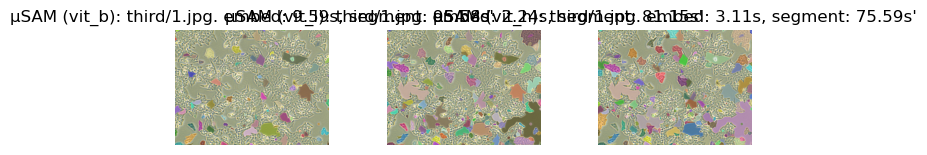

In [5]:
colors = colorcet.m_glasbey.colors

fig, axs = plt.subplots(1, 3, figsize=(13/2, 10*3/2))
plt.tight_layout()

for ax, (_, it) in zip(axs.flat, out.iterrows()):
  image = imageio.imread(it['image'])
  masks = np.load(it['masks'])

  ax.set_title(f"µSAM ({it['model']}): third/{it['imgid']}.jpg. embed: {it['T_embed']:.2f}s, segment: {it['T_segment'] + it['T_load_amg']:.2f}s'")
  ax.axis('off')

  ax.imshow(skimage.color.label2rgb(
    masks, image, saturation=1, bg_color=None, alpha=0.5, colors=colors)
  )